### `Decision Tree`

A decision tree is one of the popular and powerful machine learning algorithms that I have learned. It is a non-parametric supervised learning method that can be used for both classification and regression tasks. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

Decision tree algorithm uses Information Gain to decide the splitting points. In order to measure how much information we gain, we can use entropy to calculate the homogeneity of a sample. **Entropy** is a measure of the amount of uncertainty in a data set. Entropy controls how a Decision Tree decides to split the data. It actually affects how a Decision Tree draws its boundaries.

We can summarize the ID3 algorithm as illustrated below:

1. Compute the entropy for data-set **Entropy(D)**
    - Calculate **Entropy** (Amount of uncertainity in dataset):
$$Entropy(D) = \frac{-p}{p+n}log_{2}(\frac{p}{p+n}) - \frac{n}{p+n}log_{2}(\frac{n}{p+n})$$
    
2. For every attribute/feature:
    - Calculate entropy for all other values **Entropy(A)**
             
    - Take **Average Information Entropy** for the current attribute
        - Calculate **Average Information**:
    $$Entropy(S) = \sum\frac{p_{i}+n_{i}}{p+n}Entropy(A)$$  
    
    - Calculate **Gain** for the current attribute
        - Calculate **Information Gain**: (Difference in Entropy before and after splitting dataset on attribute A)        
$$Gain = Entropy(D) - Entropy(S)$$

3. Pick the **Highest Gain Attribute**.
4. **Repeat** until we get the tree we desired.

#### **Compute Entropy**

In [54]:
import math

def entropy(value):
    from collections import Counter

    total_instances = len(value)
    cnt = Counter(x for x in value)
    probs = [x / total_instances for x in cnt.values()]
    E = sum([-prob * math.log(prob, 2) for prob in probs])
    return E

#### **Compute Information Gain**

In [55]:
def information_gain(df, feature, target):
	df_split = df.groupby(feature)
	glist = []
	for gname, group in df_split:
		glist.append(gname)

	glist.reverse()
	nobs = len(df.index) * 1.0

	df_agg1 = df_split.agg({target: lambda x:entropy(x)})
	df_agg1.columns = ['Entropy']

	df_agg2 = df_split.agg({target: lambda x:len(x)/nobs})
	df_agg2.columns = ['Proportion']

	EA = sum(df_agg1['Entropy'] * df_agg2['Proportion'])
	ED = entropy(df[target])

	return ED - EA

#### **Building the Decision Tree**

In [56]:
def DT(df, feature, target, default_class=None):

    from collections import Counter
    cnt = Counter(x for x in df[target])

    if len(cnt) == 1:
        return next(iter(cnt))
    
    elif df.empty or (not feature):
        return default_class
    
    else:
        default_class = max(cnt.keys())
        gainz = []
        for attr in feature:
            ig = information_gain(df, attr, target)
            gainz.append(ig)

        index_of_max = gainz.index(max(gainz))
        best_attr = feature[index_of_max]
        tree = {best_attr:{}}
        remaining_attribute_names = [i for i in feature if i != best_attr]

        for attr_val, data_subset in df.groupby(best_attr):
            subtree = DT(data_subset, remaining_attribute_names, target, default_class)
            tree[best_attr][attr_val] = subtree
        return tree

#### **Classify New Data Point**

In [57]:
def classify(instance, tree, default=None):

    feature = next(iter(tree))
    if instance[feature] in tree[feature].keys():
        result = tree[feature][instance[feature]]
        if isinstance(result, dict):
            return classify(instance, result)
        else:
            return result
    else:
        return default

In [58]:
import seaborn as sns
import pandas as pd

data = sns.load_dataset('titanic')
data.loc[:, 'age'] =  data['age'].fillna(data['age'].median())

tree = DT(data, feature=['pclass', 'sex', 'age', 'fare'], target='survived')
data['Predicted'] = data.apply(classify, axis=1, args=(tree, '?'))
print(data)

     survived  pclass     sex   age  sibsp  parch     fare embarked   class  \
0           0       3    male  22.0      1      0   7.2500        S   Third   
1           1       1  female  38.0      1      0  71.2833        C   First   
2           1       3  female  26.0      0      0   7.9250        S   Third   
3           1       1  female  35.0      1      0  53.1000        S   First   
4           0       3    male  35.0      0      0   8.0500        S   Third   
..        ...     ...     ...   ...    ...    ...      ...      ...     ...   
886         0       2    male  27.0      0      0  13.0000        S  Second   
887         1       1  female  19.0      0      0  30.0000        S   First   
888         0       3  female  28.0      1      2  23.4500        S   Third   
889         1       1    male  26.0      0      0  30.0000        C   First   
890         0       3    male  32.0      0      0   7.7500        Q   Third   

       who  adult_male deck  embark_town alive  alo

#### **Building a Decision Tree using** `scikit-learn`

**Importing Libraries**

In [59]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import statsmodels.api as sm

### `Business Problem Understanding`

**Problem Statement**
Karena jumlah tips bervariasi, maka menentukan harga yang sesuai sangatlah penting bagi kesejahteraan karyawan.

**Goals**
Menentukan jumlah tip yang tepat untuk tiap customer yang berkunjung.

**Analytic Approach**
Jadi yang perlu kita lakukan adalah menganalisis data untuk dapat menemukan pola dari fitur-fitur yang ada, yang membedakan satu customer dengan customer yang lain.

Selanjutnya, kita akan membangun suatu model regresi yang akan membantu perusahaan untuk dapat menyediakan tool prediksi tip dari customer baru, yang mana akan berguna untuk meningkatkan kesejahteraan karyawan.

**Metric Evaluation**
Evaluasi metrik yang akan digunakan adalah MAE dan MSE. Semakin kecil nilai keduanya, berarti model semakin akurat dalam memprediksi harga tip sesuai dengan limitasi fitur yang digunakan.

Selain itu, kita juga bisa menurunkan nilai R-squared atau adj. R-squared untuk mengetahui seberapa baik model dapat mempresentasilam varians keseluruhan data. Semakin mendekati 1, maka semakin fit pula modelnya terhadap data observasi. Namun, metrik ini tidak valid untuk model non-linear.



### `Data Understanding`

In [60]:
import pandas as pd
data = pd.read_csv('white_wine.csv')
print(f'Jumlah baris dan kolom: {data.shape}')

data.head()

Jumlah baris dan kolom: (520, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0


In [61]:
pd.DataFrame({
    'feature': data.columns.values,
    'data_type': data.dtypes.values,
    'null': data.isna().mean().values * 100,
    'negative': [True if data[col].dtype == int and (data[col] < 0).any() else False for col in data.columns],
    'n_unique': data.nunique().values,
    'min': data.min().values,
    'max': data.max().values,
    'sample_unique': [data[col].unique() for col in data.columns]
})

,feature,data_type,null,negative,n_unique,min,max,sample_unique
0,fixed acidity,float64,0.000000,False,41,5.0000,10.2000,"[7.0, 6.3, 8.1, 7.2, 6.2, 8.6, 7.9, 6.6, 8.3, ..."
1,volatile acidity,float64,0.000000,False,69,0.1000,0.9050,"[0.27, 0.3, 0.28, 0.23, 0.32, 0.22, 0.18, 0.16..."
2,citric acid,float64,0.000000,False,59,0.0000,0.8800,"[0.36, 0.34, 0.4, 0.32, 0.16, 0.43, 0.41, 0.37..."
3,residual sugar,float64,0.000000,False,160,0.8000,22.0000,"[20.7, 1.6, 6.9, 8.5, 7.0, 1.5, 1.45, 4.2, 1.2..."
4,chlorides,float64,0.000000,False,67,0.0200,0.3460,"[0.045, 0.049, 0.05, 0.058, 0.044, 0.033, 0.03..."
5,free sulfur dioxide,float64,0.000000,False,81,3.0000,131.0000,"[45.0, 14.0, 30.0, 47.0, 28.0, 11.0, 17.0, 16...."
6,total sulfur dioxide,float64,0.000000,False,168,41.0000,313.0000,"[170.0, 132.0, 97.0, 186.0, 136.0, 129.0, 63.0..."
7,density,float64,0.000000,False,100,0.9899,1.0033,"[1.001, 0.994, 0.9951, 0.9956, 0.9949, 0.9938,..."
8,pH,float64,0.192308,False,69,2.8700,3.7200,"[3.0, 3.3, 3.26, 3.19, 3.18, 3.22, 2.99, 3.14,..."
9,sulphates,float64,0.192308,False,54,0.2700,0.8500,"[0.45, 0.49, 0.44, 0.4, 0.47, 0.56, 0.53, 0.63..."


**Insight**

- Dataset terdiri dari 520 baris dan 12 kolom.
- Semua variabel tergolong numerikal dan continous, kecuali quality yaitu diskrit
- Format data dari variabel quality seharusnya integer
- Skala dari variabel total sulfur dioxide dan free sulfur dioxide lebih besar dibanding yang lain.

### `Data Preparation`

In [62]:
df = data[['alcohol', 'density', 'quality']].copy()
df.sample(5)

,alcohol,density,quality
24,10.0,0.9951,6.0
38,8.6,0.9999,5.0
3,9.9,0.9956,6.0
315,9.1,0.9934,6.0
501,9.6,0.9975,6.0


`Duplicates`

**Duplicated Value**, Deteksi dan kuantifikasi duplikasi data

In [63]:
print(f"Jumlah duplikasi data: {df[df.duplicated()].shape}")

Jumlah duplikasi data: (115, 3)


Sebesar 22% data terindikasi duplikat, maka hilangkan salah satunya.

Handling duplikasi data:

In [64]:
df.drop_duplicates(keep='last', inplace=True, ignore_index=True)

`Missing Values`

Deteksi dan kuantifikasi missing value

<Axes: >

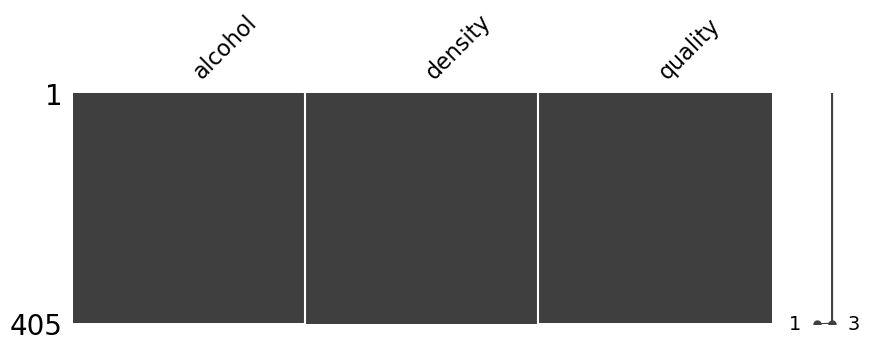

In [65]:
import missingno as msn  

msn.matrix(df, figsize=(10,3))

In [66]:
pd.DataFrame({'null': [df[col].isna().sum() for col in df.columns]}, index=df.columns.values)

,null
alcohol,1
density,0
quality,1


Dua variabel (alcohol, quality) berisi 1 point data atau 0.2% missing value.

Handling missing value:

In [67]:
df.dropna(inplace=True)

`Rare Labels`

Deteksi dan kuantifikasi rare value:

In [68]:
pd.DataFrame(df['quality'].value_counts(normalize=True) * 100).round(2)

,proportion
quality,
6.0,45.05
5.0,31.44
7.0,15.10
4.0,4.21
8.0,3.22
3.0,0.99


Lebih dari 50% didominasi oleh anggur dengan kualitas lebih dari 6.

Handling rare value:

In [69]:
import numpy as np  

df['quality'] = df['quality'].apply(lambda x: np.where(x > 6, 1, 0))

`Outliers`

Deteksi dan kuantifikasi outlier:

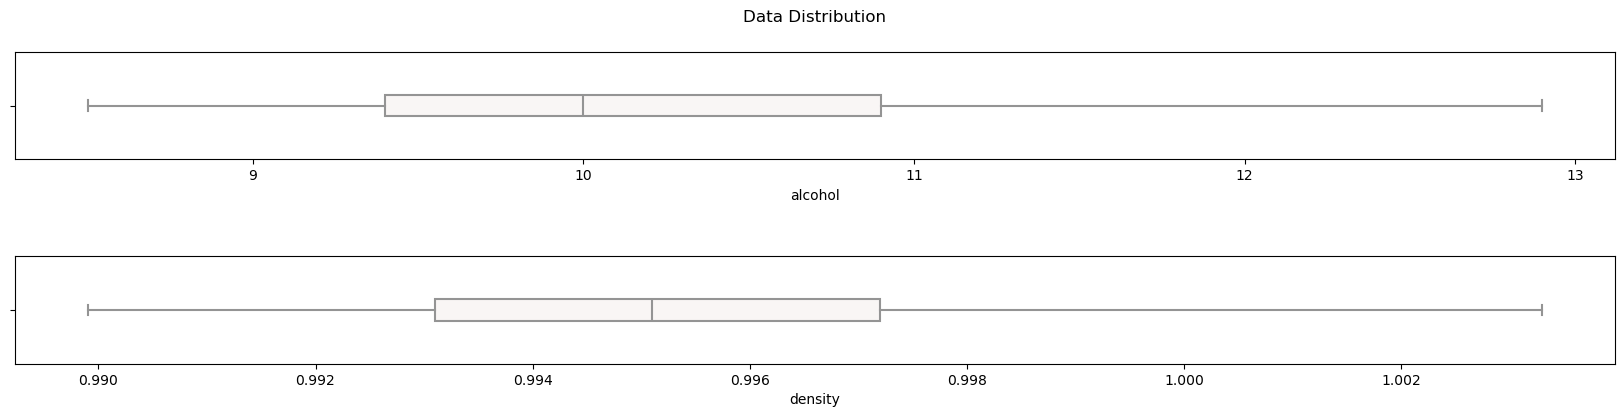

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(20, 4))

sns.boxplot(x='alcohol', data=df, width=.2, palette="vlag", ax=ax[0])
sns.boxplot(x='density', data=df, width=.2, palette="vlag", ax=ax[1])

ax[0].set_title("Data Distribution", y=1.2)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, wspace=0.1, hspace=0.9)
plt.show()


In [71]:
# Perform iqr for outlier detection

Q1 = df['density'].quantile(0.25)
Q3 = df['density'].quantile(0.75)
IQR = Q3 - Q1 

n_outlier = df['density'] >= (Q3 + 1.5*IQR)
df[n_outlier].shape

(0, 3)

Tidak terdapat outlier pada variabel density.

`Imbalance Data`

Deteksi dan kuantifikasi proporsi label target

In [72]:
df['quality'].value_counts(normalize=True) * 100

quality
0    81.683168
1    18.316832
Name: proportion, dtype: float64

Persentase jumlah label 0 (81.6%) lebih banyak dibandingkan label 1 (18.2%), ini termasuk imbalance.

`Check Multicollinearity`

Deteksi multicollinearity antar fitur dengan VIF.

In [73]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 

X = df.drop(columns='quality')
y = df['quality']

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] =  X.columns

vif.round(2)

,VIF Factor,Feature
0,88.56,alcohol
1,88.56,density


Terdapat multicollinearity antara fitur alcohol dan density. Saat menggunakan model linear, multicollinearity seharusnya dihindari. Namun untuk studi kasus ini kita akan pertahankan dahulu.

**Feature Engineering**

Bagi dataset menjadi train dan test set.

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=0, stratify=y)

X_train.shape, X_test.shape, y_test.shape, y_test.shape

((282, 2), (122, 2), (122,), (122,))

### `Model Experiment`

Setting parameter dasar untuk menginisialisasi experiment dan membuat pipeline transformasi

In [75]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

transformer = ColumnTransformer([
    ('scaling',RobustScaler(),['alcohol','density'])
], remainder='passthrough')

X_train_scale = transformer.fit_transform(X_train)
X_test_scale = transformer.fit_transform(X_test)


**Benchmark Model**

`Without Scaling`

In [76]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Define Model
estimator = DecisionTreeClassifier(max_depth=2, criterion='entropy', random_state=42)

#fitting
estimator.fit(X_train,y_train)

#predicion
y_pred_test = estimator.predict(X_test)

#calculate score
accuracy_score(y_test,y_pred_test)


0.9426229508196722

`With Scaling`

In [77]:
# Define Model
estimator = DecisionTreeClassifier(max_depth=2, criterion='entropy', random_state=42)

#fitting
estimator.fit(X_train_scale,y_train)

#predicion
y_pred_test = estimator.predict(X_test_scale)

#calculate score
accuracy_score(y_test,y_pred_test)


0.9426229508196722

- Decision Tree tidak membutuhkan scaling

**Model Selection**

In [84]:
training_accuracies = []
testing_accuracies = []

depth = range(1,20)
for i in depth:
    estimator = DecisionTreeClassifier(max_depth=i, criterion='entropy',random_state=42)
    estimator.fit(X_train, y_train)

    y_pred_train = estimator.predict(X_train)
    y_pred_test = estimator.predict(X_test)

    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    training_accuracies.append(accuracy_train)
    testing_accuracies.append(accuracy_test)

pd.DataFrame({
    'depth' : [i for i in depth],
    'Training' : training_accuracies,
    'Testing' : testing_accuracies
}).sort_values(['Testing','Training'],ascending=False)


,depth,Training,Testing
8,9,0.992908,0.983607
7,8,0.989362,0.983607
6,7,0.982270,0.983607
9,10,0.996454,0.975410
10,11,0.996454,0.975410
11,12,0.996454,0.975410
12,13,0.996454,0.975410
13,14,0.996454,0.975410
14,15,0.996454,0.975410
15,16,0.996454,0.975410


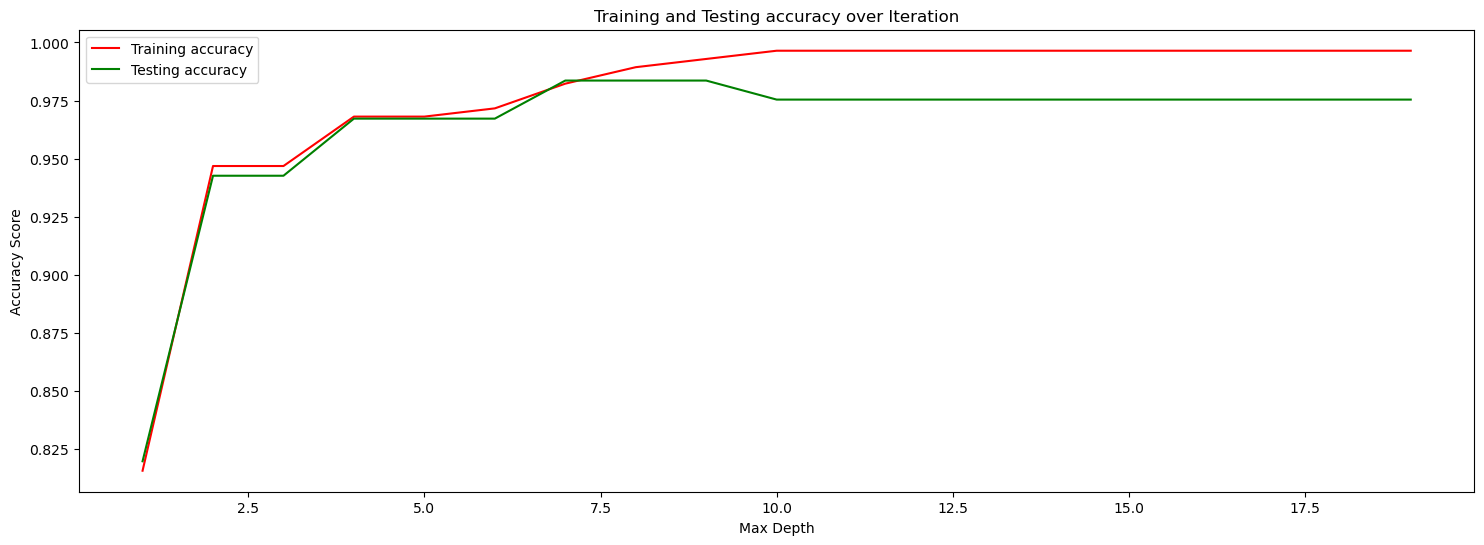

In [85]:
plt.figure(figsize=(18,6))

plt.plot(depth,training_accuracies, label = 'Training accuracy', c='red')
plt.plot(depth,testing_accuracies, label = 'Testing accuracy', c='green')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy Score')
plt.title('Training and Testing accuracy over Iteration')
plt.legend()
plt.show()

**Insight**

- Nilai max_depth yang lebih besar menghasilkan model yang lebih stabil. Hal ini membuat model tidak terlalu rentan terhadap noise pada data.

- Nilai max_depth yang lebih besar dapat menurunkan bias model, namun meningkatkan variansi hasil klasifikasi. Ini disebabkan karena model makin mudah membedakan antara kelas-kelas di wilayah dengan tiitik data yang beragam.

- Ketika max_depth meningkat, kompleksitas dan waktu komputasi untuk membuat prediksi juga meningkat, karena algoritma harus mempertimbangkan lebih untuk membuat aturan keputusan.

**Final Model**

In [ ]:
best_estimator = DecisionTreeClassifier(max_depth = 9,criterion='entropy',random_state=42)
best_estimator.fit(X_train, y_train)

y_pred_train = estimator.predict(X_train)
y_pred_test = estimator.predict(X_test)

print(f'Model training accuracy {accuracy_score}')
print(f'Model training accuracy {accuracy_score}')

**Model Interpretation**

- Akurasi pada test set : 98.36%
- Model Decision Tree mampu memprediksi 98.36% kualitas anggur dengan benar (baik yang berkualitas Good maupun Bad)
- Dari 122 botol anggur, 120 botol dilabeli dengan benar.

**Insight**: Nilai max_depth yang besar menyebabkan decision boundary cenderung lebih sensitif terhadap variasi kecil dalam data. Hal ini meningkatkan akurasi dari klasifikasi namun berpotensi cenderung overfitting karena pengaruh titik data yang noise meningkat.

`Plot Tree`

**Insight**

- Fitur alcohol disebut simpul akar (root node). Simpul ini merepresentasikan keseluruhan dataset, karena berisi aturan yang paling baik dalam membagi data menjadi dua atau lebih subset. Fitur ini dipilih untuk memaksimalkan perolehan informasi atau meminimalkan impuritas.

- Simpul internal dalam pohon mewakili titik-titik keputusan. Setiap node internal berisi aturan IF-THEN berdasarkan fitur dan ambang batas tertentu. Simpul internal akan bercabang dan berakhir di simpul daun. Setiap simpul daun diasosiasikan dengan label kelas dalam tugas klasifikasi. 

- Ukuran kedalaman pohon adalah 7 level, dihitung dari lapisan akar ke daun terdalam. Pohon yang lebih dalam dapat menangkap hubungan yang lebih kompleks dalam data tetapi juga rentan terhadap overfitting.

`Feature Importances`

**Insight**: Decision tree menentukan splitter dengan memaksimalkan information gain (penurunan impurity), dengan menghitung rerata penurunan impuritas untuk setiap fitur terhadap keseluruhan pohon akan memperoleh skor feature importance. Jadi, berdasarkan grafik di atas, fitur alcohol menjadi yang terpenting dengan rerata penurunan impuritas 0.571, diikuti dengan fitur kandungan density yaitu 0.429.

**Predict to New Data**